Assigment-2 Deep FMI - Convolutional Neural Networks

Import necessary libraries

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from random import sample
import math
import pdb

from IPython.core.debugger import set_trace


Set the parameters for training

In [2]:
lr = 0.01
momentum = 0.9
num_epochs = 5
batch_size = 16
num_cls = 10

Load **CIFAR-10** dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./ds', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./ds', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./ds/cifar-10-python.tar.gz to ./ds


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


# **TASK 1**. Define a standard convolutional network

In [4]:
class SimpleConvNet(nn.Module):
    def __init__(self, out_size=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels = 8,kernel_size= 5)
        self.pool = nn.MaxPool2d(kernel_size= 2,stride= 2)
        self.conv2 = nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size= 5)
        self.fc1 = nn.Linear(in_features= 16 * 5 * 5, out_features= 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features= 128,out_features= 64)
        self.fc3 = nn.Linear(in_features=64, out_features=out_size)


    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = SimpleConvNet(out_size=num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

# **TASK 2**. Training and evaluation

In [5]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device):
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(train_dataloader)
    
    for batch_idx, batch in tqdm(enumerate(train_dataloader)):
        batch_img, batch_labels = batch
        
        batch_img = batch_img.to(device)
        batch_labels = batch_labels.to(device)
        
        model.zero_grad()

        output = model(batch_img)

        loss = loss_crt(output, batch_labels.squeeze())       
        loss_scalar = loss.item()

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss_scalar

        pred = output.argmax(dim=1, keepdim=True)
        epoch_accuracy += pred.eq(batch_labels.view_as(pred)).float().mean().item()
        
    epoch_loss = epoch_loss/num_batches
    epoch_accuracy = 100. * epoch_accuracy/num_batches
    return epoch_loss, epoch_accuracy

def eval_epoch(model, val_dataloader, loss_crt, device):
    model.eval()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(val_dataloader)
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(val_dataloader)):

            batch_img, batch_labels = batch
            current_batch_size = batch_img.size(0)

            batch_img = batch_img.to(device)
            batch_labels = batch_labels.to(device)
 
            output = model(batch_img)

            loss = loss_crt(output, batch_labels.squeeze())
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

            pred = output.argmax(dim=1, keepdim=True)
            epoch_accuracy += pred.eq(batch_labels.view_as(pred)).float().mean().item()

    epoch_loss = epoch_loss/num_batches
    epoch_accuracy = 100. * epoch_accuracy/num_batches
    return epoch_loss, epoch_accuracy

In [7]:

# create a SGD optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=lr ,momentum=momentum)

# set up loss function
loss_criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(1, num_epochs+1):
  train_loss, train_accuracy = train_epoch(net, trainloader, loss_criterion, optimizer, device)
  val_loss, val_accuracy = eval_epoch(net, testloader, loss_criterion, device)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_accuracy)
  val_accuracies.append(val_accuracy)
  print('\nEpoch %d'%(epoch))
  print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
  print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
3125it [00:34, 91.14it/s] 
625it [00:04, 130.54it/s]


Epoch 1
train loss: 1.63138950, accuracy: 39.93200000
val loss: 1.38572043, accuracy: 50.26000000



3125it [00:32, 97.21it/s] 
625it [00:04, 127.80it/s]


Epoch 2
train loss: 1.33690245, accuracy: 52.33400000
val loss: 1.33311183, accuracy: 53.93000000



3125it [00:31, 98.62it/s] 
625it [00:04, 129.07it/s]


Epoch 3
train loss: 1.22938696, accuracy: 56.94800000
val loss: 1.29540321, accuracy: 55.18000000



3125it [00:33, 94.57it/s]
625it [00:04, 125.34it/s]


Epoch 4
train loss: 1.17542318, accuracy: 59.19200000
val loss: 1.23594410, accuracy: 58.05000000



3125it [00:32, 95.30it/s] 
625it [00:04, 128.34it/s]


Epoch 5
train loss: 1.14037511, accuracy: 60.55200000
val loss: 1.23365328, accuracy: 58.55000000


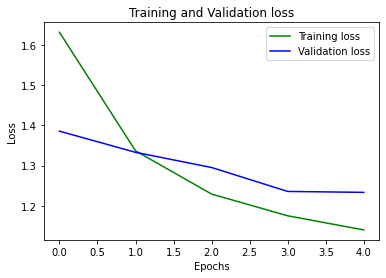

In [12]:
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

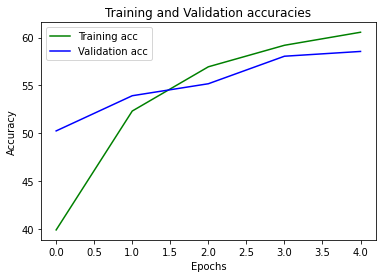

In [13]:
plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training acc')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation acc')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **TASK 3**. Implement a linear layer. 

In [8]:

class myLinear(nn.Module):
  def __init__(self, in_features, out_features, device=None):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features
    # initialise parameters
    # weight shape: [in, out]
    # bias shape: [out]
    
    self.weight = torch.nn.parameter.Parameter(
        torch.empty(out_features, in_features)
        #torch.empty((out_features, in_features))
    )
    self.bias = torch.nn.parameter.Parameter(
        torch.empty(out_features)
    )

    self.reset_parameters()
 
  def reset_parameters(self):
    self.scale = 1.0 / math.sqrt(self.in_features)
    nn.init.uniform(self.weight, -self.scale, self.scale)
    nn.init.uniform_(self.bias, -self.scale, self.scale)

  def forward(self, x):
    # weight shape: [out, in]
    # x shape: [batch, in]
    # we want do matrix multiplication between the weight and each element in the batch x[i] (seen as a column vector)
    # y[i] = W x[i]

    # in order to do this we rely on broadcasting in torch.matmul and must reshape x as [batch, in , 1]  
    # such that the matrix multiplication is done on dimmensions [out, in] [in, 1] -> [out, 1]
    # (https://pytorch.org/docs/stable/generated/torch.matmul.html)

    # TODO
    # compute the linear operation using torch.matmul
    x = x.to(device)
    x = torch.unsqueeze(x,-1)
    y = torch.matmul(self.weight, x).to(device)

    # we add the same bias column vector to each element in the batch y[i] = y[i] + bias
    # we rely again on broadcasting and make the bias have dimension [1, out, 1] 
    # such that it aligns with y of shape [batch, out, 1]

    # TODO add bias 
    y = y + self.bias.reshape(1,self.out_features,1)
    y = torch.squeeze(y)

    return y

In [ ]:
# define two linear layers
linear = nn.Linear(8, 16)
linear.to(device)
mylinear = myLinear(8, 16)
mylinear.to(device)

mylinear.load_state_dict(linear.state_dict())
# TODO: compute the difference be twen the two layers
# on random input
x = torch.randn((8,8))
x=x.to(device)
print(linear.forward(x) - mylinear.forward(x))


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0', grad_fn=<SubBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


# **Task 4**. Implement Conv2d layer

In [9]:
class myConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, device=None):
    super(myConv2d, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    # initialise parameters
    scale = 1.0 / math.sqrt(in_channels * kernel_size * kernel_size)
    self.weight = torch.nn.parameter.Parameter(
        torch.rand(out_channels, in_channels, kernel_size, kernel_size)
        #torch.empty((out_features, in_features))
    )
    self.bias = torch.nn.parameter.Parameter(
        torch.rand(out_channels)
    )

    self.reset_parameters()
 
  def reset_parameters(self):
    self.scale = 1.0 / math.sqrt(self.in_channels * self.kernel_size * self.kernel_size )
    nn.init.uniform(self.weight, -self.scale, self.scale)
    nn.init.uniform_(self.bias, -self.scale, self.scale)

  def forward(self, x):
    b,c_in,h,w = x.shape
    out_h = h - self.kernel_size + 1
    out_w = w - self.kernel_size + 1

    y = torch.zeros((b,self.out_channels,out_h,out_w)).to(device)

    for batch in range(b):
      for channel in range(self.out_channels):
        for i in range(out_h):
          for j in range(out_w):
            window = x[batch, :, i:i+self.kernel_size, j:j+self.kernel_size]
            window = window.to(device)
            mult = torch.mul(window, self.weight[channel,:,:,:]).to(device)
            y[batch,channel,i,j] = torch.sum(mult) + self.bias[channel]

    return y

In [ ]:
x = torch.randn(1, 3, 32, 32)
x = x.to(device)
conv = nn.Conv2d(3, 16, kernel_size=3)
conv.to(device)
myconv = myConv2d(3, 16, kernel_size=3)
myconv.to(device)
myconv.load_state_dict(conv.state_dict())
print(myconv(x)-conv(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


tensor([[[[ 0.0000e+00, -1.1921e-07,  0.0000e+00,  ..., -3.2783e-07,
            1.1921e-07,  0.0000e+00],
          [ 1.1921e-07, -2.3842e-07,  0.0000e+00,  ..., -1.1921e-07,
            1.1921e-07,  1.4901e-07],
          [ 0.0000e+00,  0.0000e+00, -2.3842e-07,  ..., -3.1292e-07,
            0.0000e+00,  1.4901e-08],
          ...,
          [ 0.0000e+00, -1.1921e-07,  2.3842e-07,  ..., -5.9605e-08,
           -4.7684e-07,  3.7253e-08],
          [ 1.4901e-07, -1.1921e-07, -2.9802e-08,  ...,  1.1921e-07,
            1.1921e-07,  1.1921e-07],
          [ 1.7881e-07,  4.4703e-08, -1.4901e-07,  ...,  0.0000e+00,
           -5.9605e-08,  2.3842e-07]],

         [[ 1.9372e-07, -5.9605e-08, -1.1921e-07,  ...,  8.9407e-08,
            0.0000e+00,  2.9802e-08],
          [ 2.3842e-07, -1.1921e-07,  7.4506e-08,  ..., -1.4901e-08,
           -5.9605e-08, -5.9605e-08],
          [-1.1921e-07,  0.0000e+00,  5.9605e-08,  ..., -2.9802e-08,
           -5.9605e-08,  5.9605e-08],
          ...,
     

# **TASK 5**. Evaluate your implementation of convolutional network. 

In [10]:

class mySimpleConvNet(nn.Module):
    def __init__(self, out_size=10):
        super().__init__()
        self.conv1 = myConv2d(3, 8, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = myConv2d(8, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = myLinear(16 * 5 * 5, 128)
        self.relu = nn.ReLU()
        self.fc2 = myLinear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = myLinear(64, out_size)



    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


my_net = mySimpleConvNet(out_size=num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_net = my_net.to(device)
my_net.load_state_dict(net.state_dict())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


<All keys matched successfully>

In [11]:
import time

testloader_mynet = torch.utils.data.DataLoader(testset, batch_size=20, shuffle=False)
my_net.eval()
net.eval()
for batch_idx, batch in tqdm(enumerate(testloader_mynet)):

    batch_img, batch_labels = batch

    batch_img = batch_img.to(device)
    batch_labels = batch_labels.to(device)

    t1 = time.time()
    output_mynet = my_net(batch_img)
    t2 = time.time()
    output_net   = net(batch_img)
    t3 = time.time()


    pred_mynet = output_mynet.argmax(dim=1, keepdim=True)
    mynet_accuracy = pred_mynet.eq(batch_labels.view_as(pred_mynet)).float().mean().item()
    pred_net = output_net.argmax(dim=1, keepdim=True)
    net_accuracy = pred_net.eq(batch_labels.view_as(pred_net)).float().mean().item()
    print("My net: ",mynet_accuracy,"deafult net: ",net_accuracy)
    print("My net time :",t2-t1)
    print("default time:",t3-t2)
    print("Ratio", (t2-t1)/(t3-t2))
    break # we only take the first batch, with 20 samples

0it [00:26, ?it/s]

My net:  0.6500000357627869 deafult net:  0.6500000357627869
My net time : 26.425207138061523
default time: 0.0017075538635253906
Ratio 15475.47500698129


The accuracy is the same, but the time is considerably slower on our implementation

# **TASK 6**. Feature map visualization

Define function to show and title an image